# Loading Model, Dataset

In [1]:
from PIL import Image
from torchvision import models,transforms
from matplotlib.colors import LinearSegmentedColormap
from torchvision.models import VGG16_Weights,ResNet18_Weights
from captum.attr import LRP,Occlusion,NoiseTunnel,GradientShap,IntegratedGradients,visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule,GammaRule
import json,torch,numpy as np,torch.nn.functional as F
model=models.resnet18(weights=ResNet18_Weights.DEFAULT)
model=model.eval()
labels_path='imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels=json.load(json_data)
transform=transforms.Compose([transforms.Resize(256),
                              transforms.CenterCrop(224),
                              transforms.ToTensor()])
transform_normalize=transforms.Normalize(mean=[0.485,0.456,0.406],
                                         std=[0.229,0.224,0.225])
img=Image.open('swan-3299528_1280.jpg')
transformed_img=transform(img)
input=transform_normalize(transformed_img)
input=input.unsqueeze(0)
input.requires_grad_()
output=model(input)
output=F.softmax(output,dim=1)
prediction_score,pred_label_idx=torch.topk(output,1)
pred_label_idx.squeeze_()
predicted_label=idx_to_labels[str(pred_label_idx.item())][1]
print(f'Predicted: {predicted_label} ({prediction_score.squeeze().item()})')

Predicted: goose (0.45548662543296814)


# Gradient-Based Attribution

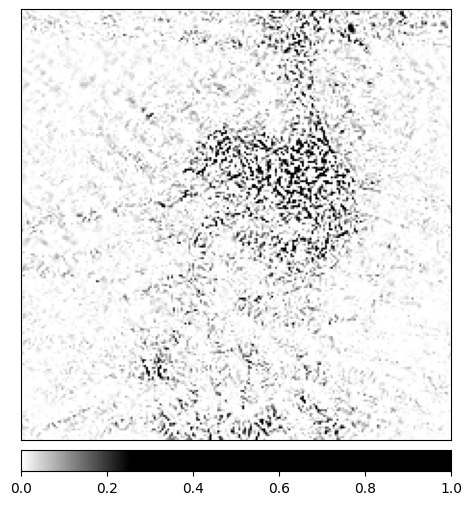

In [2]:
integrated_gradients=IntegratedGradients(model)
attributions_ig=integrated_gradients.attribute(input,target=pred_label_idx,n_steps=200)
default_cmap=LinearSegmentedColormap.from_list('custom blue',[(0,'#ffffff'),
                                                              (0.25,'#000000'),
                                                              (1,'#000000')],N=256)
_=viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(),(1,2,0)),np.transpose(transformed_img.squeeze().cpu().detach().numpy(),(1,2,0)),method='heat_map',cmap=default_cmap,show_colorbar=True,sign='positive',outlier_perc=1)

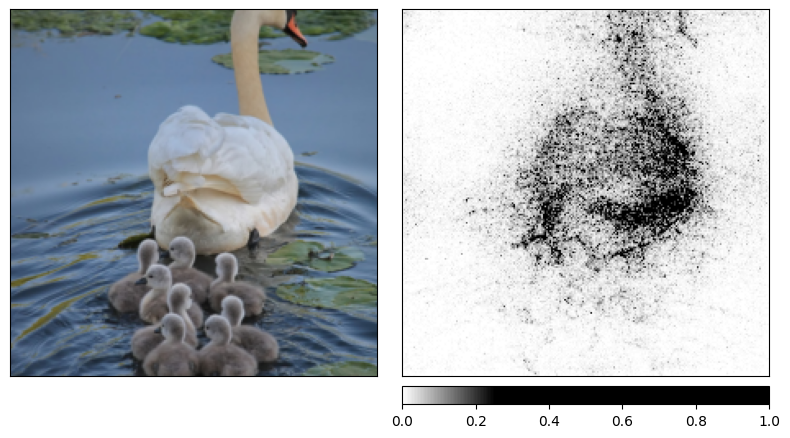

In [3]:
noise_tunnel=NoiseTunnel(integrated_gradients)
attributions_ig_nt=noise_tunnel.attribute(input,nt_samples=10,nt_type='smoothgrad_sq',target=pred_label_idx)
_=viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(),(1,2,0)),np.transpose(transformed_img.squeeze().cpu().detach().numpy(),(1,2,0)),['original_image','heat_map'],['all','positive'],cmap=default_cmap,show_colorbar=True)

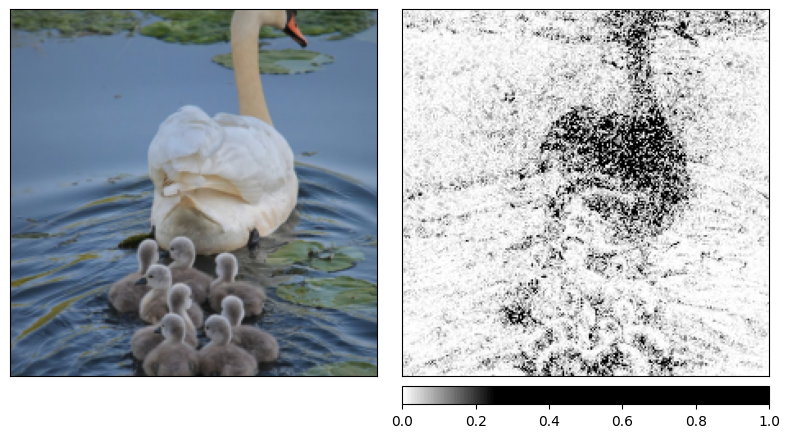

In [4]:
gradient_shap=GradientShap(model)
rand_img_dist=torch.cat([input*0,
                         input*1])
attributions_gs=gradient_shap.attribute(input,n_samples=50,stdevs=0.0001,baselines=rand_img_dist,target=pred_label_idx)
_=viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(),(1,2,0)),np.transpose(transformed_img.squeeze().cpu().detach().numpy(),(1,2,0)),['original_image','heat_map'],['all','absolute_value'],cmap=default_cmap,show_colorbar=True)

# Occlusion-Based Attribution

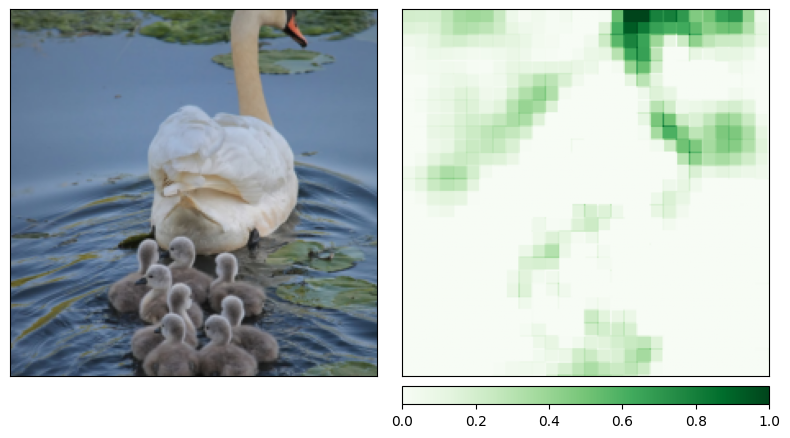

In [5]:
occlusion=Occlusion(model)
attributions_occ=occlusion.attribute(input,strides=(3,8,8),target=pred_label_idx,sliding_window_shapes=(3,15,15),baselines=0)
_=viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(),(1,2,0)),np.transpose(transformed_img.squeeze().cpu().detach().numpy(),(1,2,0)),['original_image','heat_map'],['all','positive'],show_colorbar=True,outlier_perc=2)

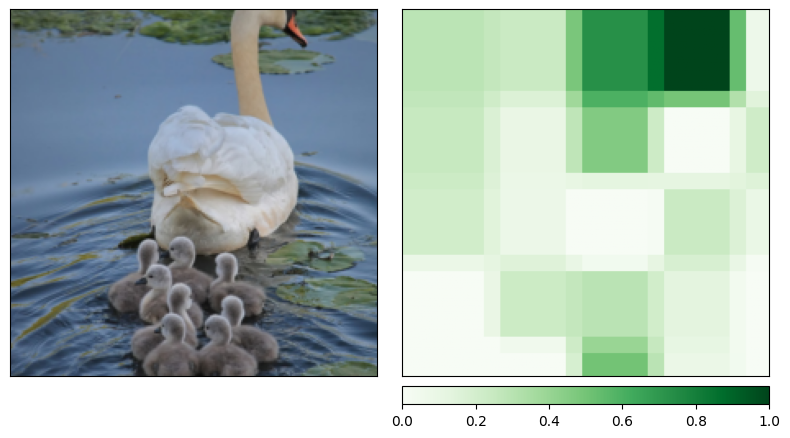

In [6]:
attributions_occ=occlusion.attribute(input,strides=(3,50,50),target=pred_label_idx,sliding_window_shapes=(3,60,60),baselines=0)
_=viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(),(1,2,0)),np.transpose(transformed_img.squeeze().cpu().detach().numpy(),(1,2,0)),['original_image','heat_map'],['all','positive'],show_colorbar=True,outlier_perc=2)

# LRP-Based Attribution

In [7]:
model=models.vgg16(weights=VGG16_Weights.DEFAULT)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

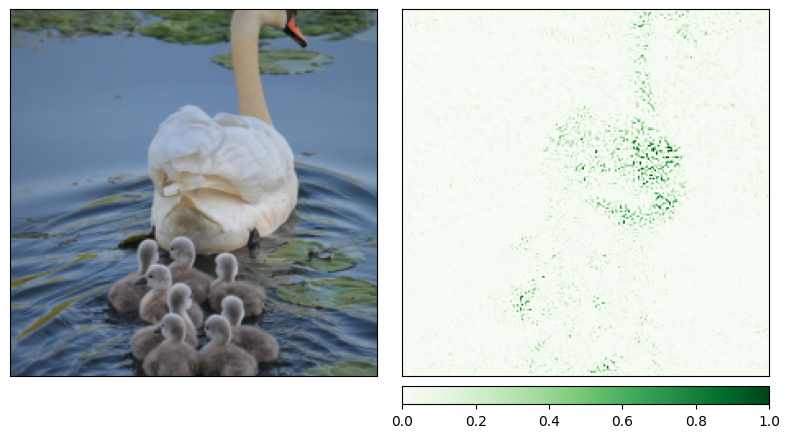

In [8]:
lrp=LRP(model)
attributions_lrp=lrp.attribute(input,target=pred_label_idx)
_=viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(),(1,2,0)),np.transpose(transformed_img.squeeze().cpu().detach().numpy(),(1,2,0)),['original_image','heat_map'],['all','positive'],show_colorbar=True,outlier_perc=2)

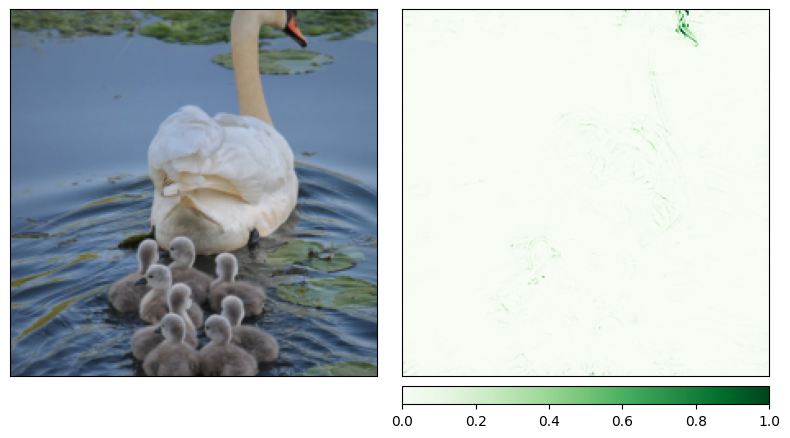

In [9]:
layers=list(model._modules['features'])+list(model._modules['classifier'])
num_layers=len(layers)
for idx_layer in range(1,num_layers):
    if idx_layer<=16:
        setattr(layers[idx_layer],'rule',GammaRule())
    elif 17<=idx_layer<=30:
        setattr(layers[idx_layer],'rule',EpsilonRule())
    elif idx_layer>=31:
        setattr(layers[idx_layer],'rule',EpsilonRule(epsilon=0))
attributions_lrp=lrp.attribute(input,target=pred_label_idx)
_=viz.visualize_image_attr_multiple(np.transpose(attributions_lrp.squeeze().cpu().detach().numpy(),(1,2,0)),np.transpose(transformed_img.squeeze().cpu().detach().numpy(),(1,2,0)),['original_image','heat_map'],['all','positive'],show_colorbar=True,outlier_perc=2)